# Tutorial Warning Class

In [1]:
import numpy as np
from scipy import sparse
import xarray as xr

from climada_petals.engine.warn import Warn, FilterData
from climada.util.plot import geo_scatter_categorical
from climada.entity import ImpfTropCyclone, ImpactFuncSet
from climada.util.api_client import Client


kwargs = dict()
kwargs['cmap'] = 'Wistia'

# MCH Example

In [2]:
# Get data via client
client = Client()
dataset = client.get_dataset_info(name="cosmo2_2019121400")
path_files = client.download_dataset(dataset)[1][0]
ncdf = xr.open_dataset(path_files)
wind_matrix = ncdf.VMAX_10M.values[0, :, :]

lon = ncdf.lon_1.values
lat = ncdf.lat_1.values
coord = np.vstack((lat.flatten(), lon.flatten())).transpose()

array([<GeoAxesSubplot:title={'center':'Warning generated by MeteoSwiss Defautls'}>],
      dtype=object)

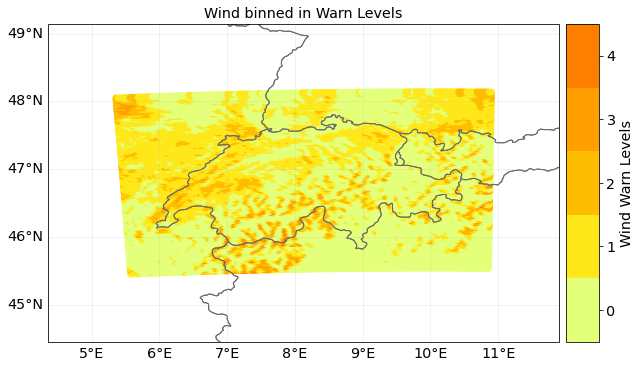

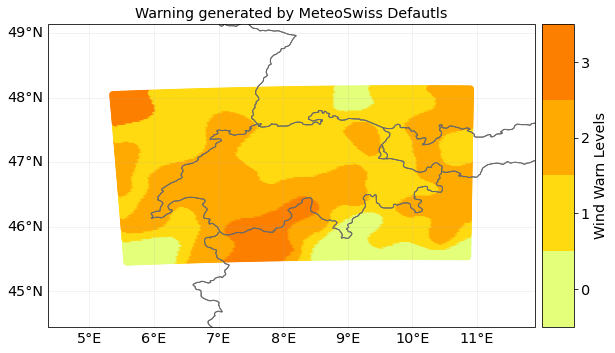

In [3]:
# Define warn levels and default operations for algorithm
warn_levels = np.array([0.0, 19.44, 25.0, 30.55, 38.88, 300.0])
filter_data_only_binning = FilterData(warn_levels, operations=[], sizes=[], gradual_decr=False, change_sm=False, size_sm=0)
filter_data_default = FilterData.wind_mch_default(warn_levels)

# no filtering, only binning
binned_map = Warn.from_map(wind_matrix, coord, filter_data_only_binning)
binned_map.plot_warning(var_name='Wind Warn Levels', title='Wind binned in Warn Levels', **kwargs)
# filtering with default operations
default_op_warning = Warn.from_map(wind_matrix, coord, filter_data_default)
default_op_warning.plot_warning(var_name='Wind Warn Levels', title='Warning generated by MeteoSwiss Defautls', **kwargs)

array([<GeoAxesSubplot:title={'center':'Warning generated with Combination of Operations'}>],
      dtype=object)

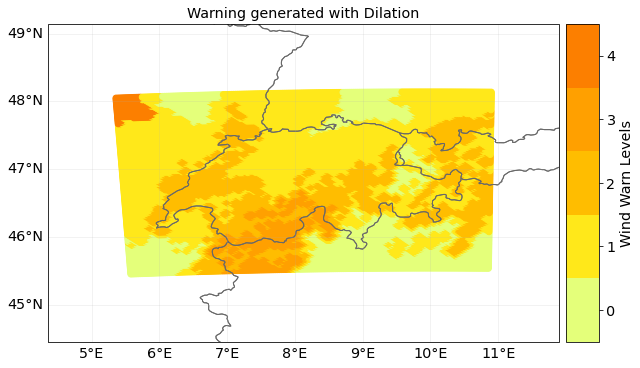

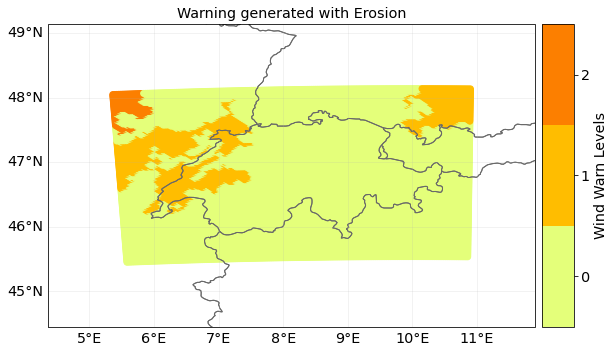

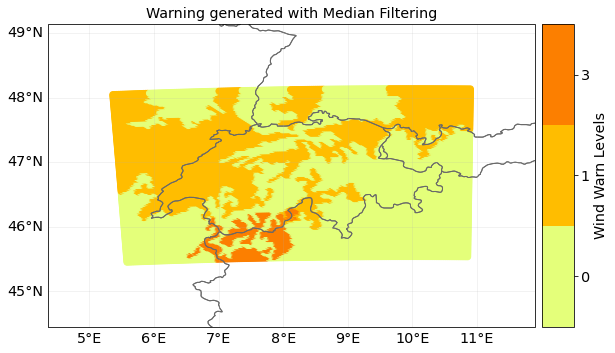

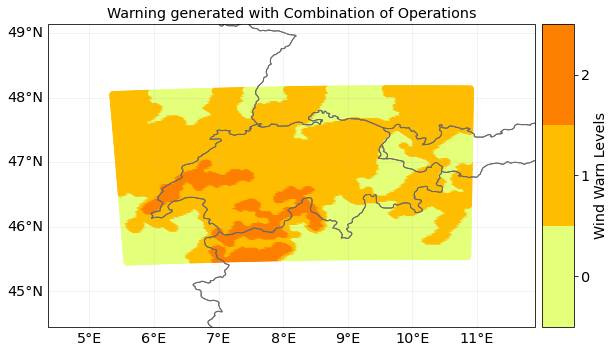

In [4]:
# Apply operations separately
# only dilation
filter_data = FilterData.wind_mch_default(warn_levels, operations=['DILATION'], sizes=[2])
warn_dilation_only = Warn.from_map(wind_matrix, coord, filter_data)
warn_dilation_only.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Dilation', **kwargs)
# only erosion
filter_data = FilterData.wind_mch_default(warn_levels, operations=['EROSION'], sizes=[2])
warn_erosion_only = Warn.from_map(wind_matrix, coord, filter_data)
warn_erosion_only.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Erosion', **kwargs)
# only median filtering
filter_data = FilterData.wind_mch_default(warn_levels, operations=['MEDIANFILTERING'], sizes=[3])
warn_median_only = Warn.from_map(wind_matrix, coord, filter_data)
warn_median_only.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Median Filtering', **kwargs)
# first ersoion, then dilation, then median filtering
filter_data = FilterData.wind_mch_default(warn_levels, operations=['EROSION', 'DILATION', 'MEDIANFILTERING'], sizes=[1, 3, 3])
warn_combination = Warn.from_map(wind_matrix, coord, filter_data)
warn_combination.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Combination of Operations', **kwargs)

array([<GeoAxesSubplot:title={'center':'Warning wihtout Gradual Decrease'}>],
      dtype=object)

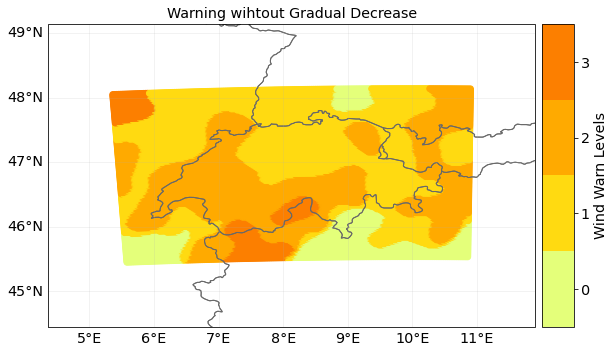

In [5]:
# Warning without gradual decrease of regions of higher level to lower levels
filter_data = FilterData.wind_mch_default(warn_levels, gradual_decr=False)
warn_wo_grad = Warn.from_map(wind_matrix, coord, filter_data)
warn_wo_grad.plot_warning(var_name='Wind Warn Levels', title='Warning wihtout Gradual Decrease', **kwargs)

array([<GeoAxesSubplot:title={'center':'Warning wihtout Removing too small Regions'}>],
      dtype=object)

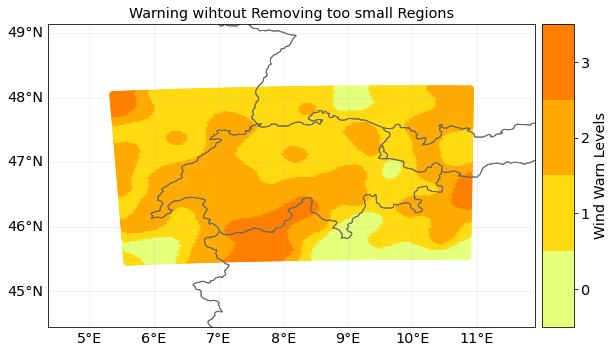

In [6]:
# Warning without change too small regions by setting levels newly
filter_data = FilterData.wind_mch_default(warn_levels, change_sm=False)
warn_not_changed = Warn.from_map(wind_matrix, coord, filter_data)
warn_not_changed.plot_warning(var_name='Wind Warn Levels', title='Warning wihtout Removing too small Regions', **kwargs)

# CLIMADA Impact Example - Haiti

In [7]:
tc_dataset_infos = client.list_dataset_infos(data_type='tropical_cyclone')
client.get_property_values(tc_dataset_infos, known_property_values = {'country_name':'Haiti'})

{'res_arcsec': ['150'],
 'climate_scenario': ['rcp26', 'rcp45', 'rcp85', 'historical', 'rcp60'],
 'ref_year': ['2040', '2060', '2080'],
 'nb_synth_tracks': ['50', '10'],
 'spatial_coverage': ['country'],
 'tracks_year_range': ['1980_2020'],
 'country_iso3alpha': ['HTI'],
 'country_name': ['Haiti'],
 'country_iso3num': ['332']}

2022-04-21 16:42:32,171 - climada.hazard.base - INFO - Reading /Users/robertblass/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040/v1/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040.hdf5


array([<GeoAxesSubplot:title={'center':'Categorical Warning Map'}>],
      dtype=object)

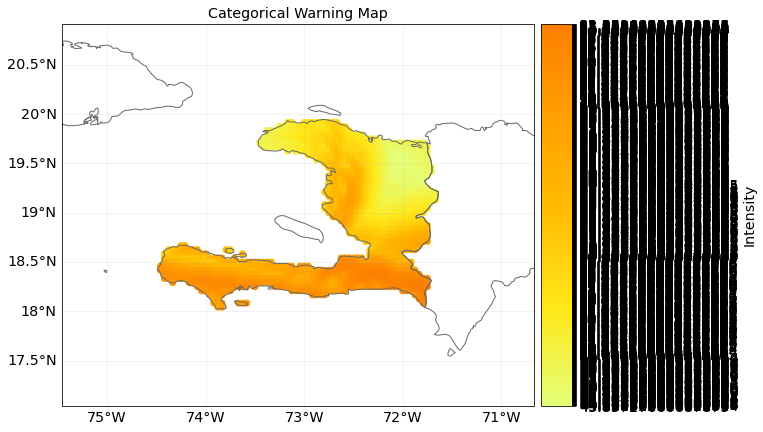

In [8]:
# Read hazard
tc_haiti = client.get_hazard('tropical_cyclone', properties={'country_name': 'Haiti', 'climate_scenario': 'rcp45', 'ref_year':'2040', 'nb_synth_tracks':'10'})
tc_haiti.intensity = sparse.csr_matrix(tc_haiti.intensity.max(axis=0))

lon = tc_haiti.centroids.lon
lat = tc_haiti.centroids.lat
coord_haiti = np.vstack((lat.flatten(), lon.flatten())).transpose()

geo_scatter_categorical(tc_haiti.intensity.todense().flatten(), coord_haiti, 'Intensity', 'Categorical Warning Map', cmap='Wistia')

In [9]:
# Function to pad country shape with zeros to form rectangle (as needed by algorithm)
def zeropadding(lat_, lon_, val):
    lat = np.round(lat_, decimals=12)
    lon = np.round(lon_, decimals=12)
    
    un_y = np.sort(np.unique(lat))
    un_x = np.sort(np.unique(lon))

    y = lat
    y0 = min(y)
    dy = abs(un_y[1] - un_y[0])
    x = lon
    x0 = min(x)
    dx = abs(un_x[1] - un_x[0])

    i = ((y - y0) / dy).astype(int)
    j = ((x - x0) / dx).astype(int)
    grid = np.zeros((len(np.unique(lat)), len(np.unique(lon))))
    grid[i, j] = val
    
    xx, yy = np.meshgrid(un_x, un_y)
    coord_ = np.vstack((yy.flatten(), xx.flatten())).transpose()
    
    return grid, coord_

array([<GeoAxesSubplot:title={'center':'Binned Intensity'}>], dtype=object)

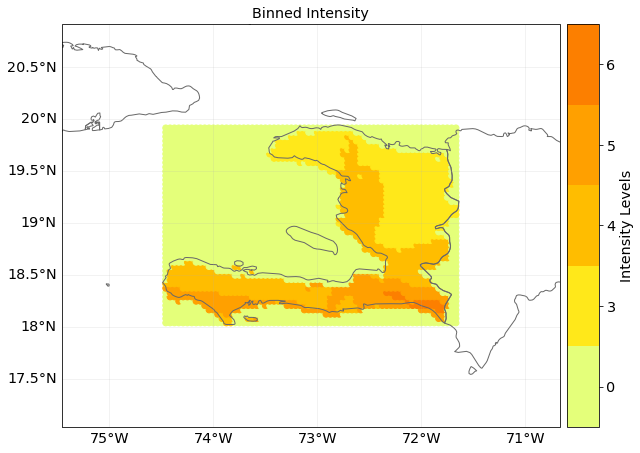

In [10]:
# Plot binned intensities
# warn Levels
warn_levels = [0, 20, 30, 40, 60, 70, 80, 1000]
grid, coord_haiti = zeropadding(tc_haiti.centroids.lat, tc_haiti.centroids.lon, tc_haiti.intensity.todense())

# no filtering operations applied - only binning as reference
filter_data_only_binning = FilterData(warn_levels, operations=[], sizes=[], gradual_decr=False, change_sm=False, size_sm=0)
binned_only = Warn.from_map(grid, coord_haiti, filter_data_only_binning)
binned_only.plot_warning(var_name='Intensity Levels', title='Binned Intensity', **kwargs)

array([<GeoAxesSubplot:title={'center':'Intensity Map generated by finetuned Operations'}>],
      dtype=object)

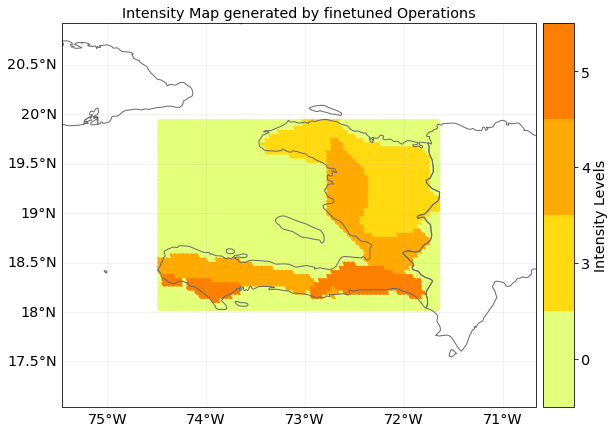

In [12]:
# Apply finetuned filtering operations without gradual decrease and changing too small regions
filter_data = FilterData(warn_levels, operations=['DILATION', 'EROSION', 'MEDIANFILTERING'], sizes=[1, 1, 5], gradual_decr=False, change_sm=False, size_sm=0)
warn_def = Warn.from_map(grid, coord_haiti, filter_data)
warn_def.plot_warning(var_name='Intensity Levels', title='Intensity Map generated by finetuned Operations', **kwargs)

array([<GeoAxesSubplot:title={'center':'Intensity Map generated with Gradual Decrease'}>],
      dtype=object)

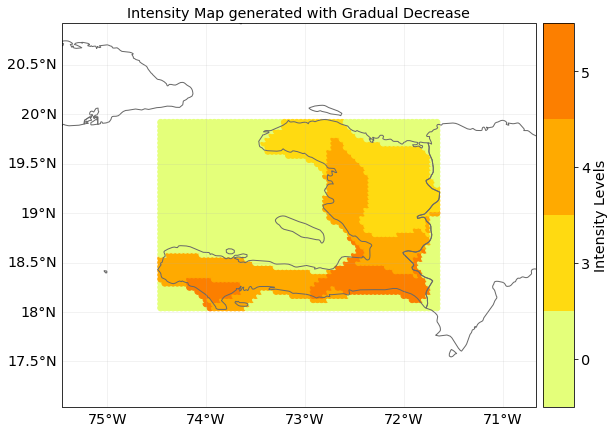

In [13]:
# Map generated with gradual decrease and changing too small regions to surrounding
filter_data = FilterData(warn_levels, operations=['DILATION', 'EROSION', 'MEDIANFILTERING'], sizes=[1, 1, 5], gradual_decr=True, change_sm=True, size_sm=50)
warn_def = Warn.from_map(grid, coord_haiti, filter_data)
warn_def.plot_warning(var_name='Intensity Levels', title='Intensity Map generated with Gradual Decrease', **kwargs)

# Impact Example Haiti

In [14]:
# Example on impact data to show how any 2D map can be clustered and smoothed with this class
# get data
exp_haiti = client.get_litpop_default(country="Haiti")

2022-04-21 16:50:55,495 - climada.entity.exposures.base - INFO - Reading /Users/robertblass/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v1/LitPop_150arcsec_HTI.hdf5


In [15]:
impf = ImpfTropCyclone().from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf)

/Users/robertblass/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':"LitPop Exposure for ['HTI'] at 150 as, year: 2018, financial mode: pc,\nexp: [1, 1], admin1_calc: False"}>

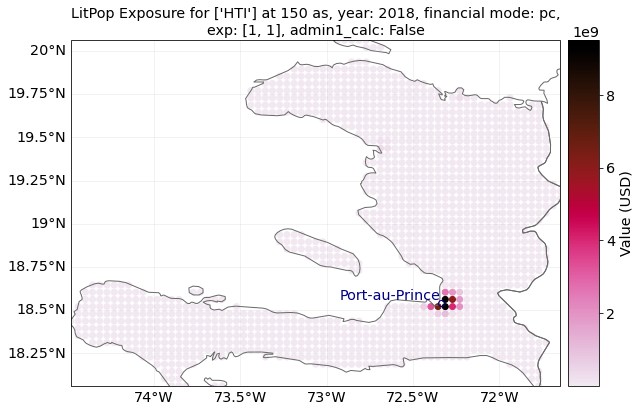

In [16]:
exp_haiti.plot_scatter()

In [17]:
lat, lon, values = exp_haiti.gdf.latitude.to_numpy(), exp_haiti.gdf.longitude.to_numpy(), exp_haiti.gdf.value.to_numpy()
grid, coord_impf = zeropadding(lat, lon, values)

array([<GeoAxesSubplot:title={'center':'Impact Data'}>], dtype=object)

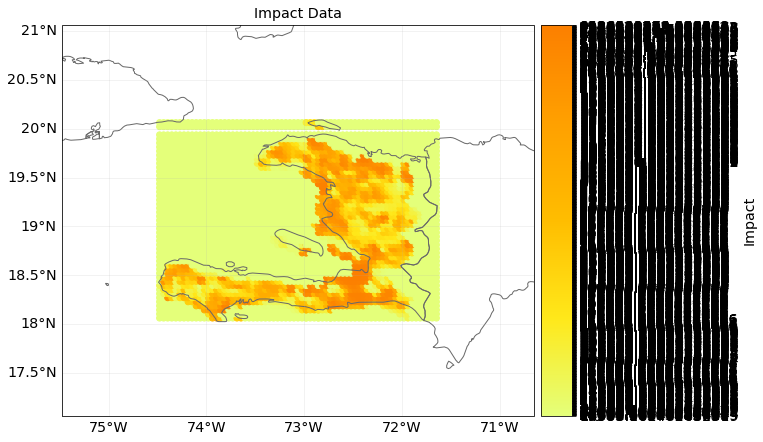

In [18]:
geo_scatter_categorical(grid.flatten(), coord_impf, 'Impact', 'Impact Data', cmap='Wistia')

array([<GeoAxesSubplot:title={'center':'Impact binned into Levels'}>],
      dtype=object)

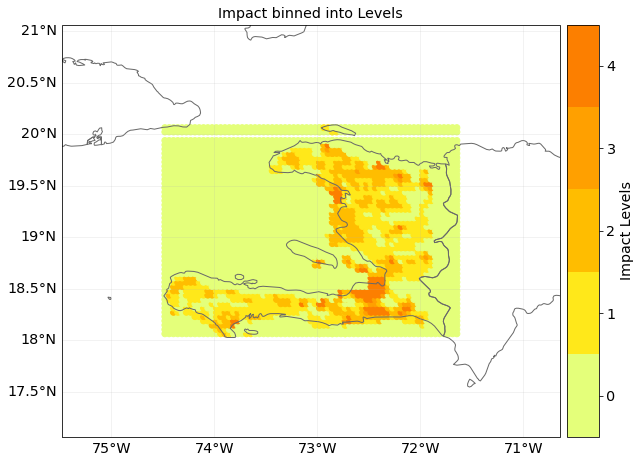

In [19]:
# Bin data into levels
levels = [0, 500000, 1000000, 6000000, 10000000, 10000000000]
filter_data = FilterData(levels, operations=[], sizes=[], gradual_decr=False, change_sm=False, size_sm=0)
warn_def = Warn.from_map(grid, coord_impf, filter_data)
warn_def.plot_warning(var_name='Impact Levels', title='Impact binned into Levels', **kwargs)

array([<GeoAxesSubplot:title={'center':'Impact clustered into Levels'}>],
      dtype=object)

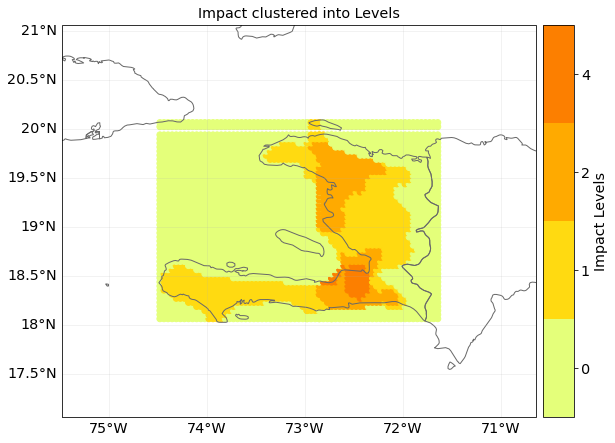

In [20]:
# Apply finetuned filtering operations with gradual decrease and changing too small regions
warn_levels = [0, 500000, 1000000, 6000000, 10000000,   10000000000]
filter_data = FilterData(warn_levels, operations=['DILATION', 'EROSION', 'MEDIANFILTERING'], sizes=[1, 1, 5], gradual_decr=True, change_sm=True, size_sm=50)
warn_def = Warn.from_map(grid, coord_impf, filter_data)
warn_def.plot_warning(var_name='Impact Levels', title='Impact clustered into Levels', **kwargs)